In [1]:
%load_ext autoreload
%autoreload 2


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import pickle
import networkx as nx
from pathlib import Path
from glob import glob
from tqdm import tqdm
from collections import defaultdict

os.getcwd()

from graph_creator.create_graph import get_scenario_data, plot_scene_at_timestep
from graph_creator.MapGraph import MapGraph
from graph_creator.ActorGraph import ActorGraph
from subgraphs.subgraph_types import get_all_subgraphs


# Node Coverage Visualization


In [7]:
repo_root = Path.cwd()
while not (repo_root / ".git").exists() and repo_root != repo_root.parent:
    repo_root = repo_root.parent

GRAPH_ROOT = repo_root / "actor_graphs" / "argoverse"
SUBGRAPH_NAME = "cut_in"
MAX_GRAPHS = 100

In [8]:
actor_graph_paths = sorted(GRAPH_ROOT.glob('*_actor_graph.pkl'))[:MAX_GRAPHS]

graph_data = []
for actor_graph_path in tqdm(actor_graph_paths, desc="Loading actor graphs"):
    with open(actor_graph_path, "rb") as f:
        actor_graph = pickle.load(f)
    for timestamp, G_nx in actor_graph.actor_graphs.items():
        graph_data.append({
            'actor_graph_path': str(actor_graph_path),
            'timestamp': timestamp,
            'graph': G_nx
        })

Loading actor graphs: 100%|██████████| 100/100 [00:01<00:00, 67.03it/s]


In [9]:
coverage_graphs = get_all_subgraphs()
node_match = ["actor_type", "lane_change", "is_on_intersection"]
edge_match = ["edge_type"]

node_coverage_data = []
for graph_info in tqdm(graph_data, desc="Counting node coverage"):
    actor_graph_path = graph_info['actor_graph_path']
    timestamp = graph_info['timestamp']
    ag_nx = graph_info['graph']
    
    graph_id = f"{actor_graph_path}_{timestamp}"
    
    for subgraph_name, subgraph_template in coverage_graphs.items():
        GM = nx.algorithms.isomorphism.DiGraphMatcher(
            ag_nx, subgraph_template,
            node_match=nx.algorithms.isomorphism.categorical_node_match(
                node_match, [None] * len(node_match)
            ),
            edge_match=nx.algorithms.isomorphism.categorical_edge_match(
                edge_match, [None] * len(edge_match)
            )
        )
        
        node_coverage_count = defaultdict(int)
        for mapping in GM.subgraph_isomorphisms_iter():
            for node_id in mapping.keys():
                node_coverage_count[node_id] += 1
        
        all_nodes = set(ag_nx.nodes())
        covered_nodes = set(node_coverage_count.keys())
        
        for node_id, count in node_coverage_count.items():
            node_coverage_data.append({
                'graph_path': graph_id,
                'actor_graph_path': actor_graph_path,
                'timestamp': timestamp,
                'node_id': node_id,
                'subgraph_name': subgraph_name,
                'coverage_count': count
            })
        
        uncovered_nodes = all_nodes - covered_nodes
        for node_id in uncovered_nodes:
            node_coverage_data.append({
                'graph_path': graph_id,
                'actor_graph_path': actor_graph_path,
                'timestamp': timestamp,
                'node_id': node_id,
                'subgraph_name': subgraph_name,
                'coverage_count': 0
            })

coverage_df = pd.DataFrame(node_coverage_data)


Counting node coverage: 100%|██████████| 1100/1100 [00:02<00:00, 455.08it/s]


In [10]:
coverage_df

,graph_path,actor_graph_path,timestamp,node_id,subgraph_name,coverage_count
0,/Users/marius/code/graph_coverage/actor_graphs...,/Users/marius/code/graph_coverage/actor_graphs...,1.0,41303,lead_vehicle_in_front_with_neighbor_vehicle,0
1,/Users/marius/code/graph_coverage/actor_graphs...,/Users/marius/code/graph_coverage/actor_graphs...,1.0,41043,lead_vehicle_in_front_with_neighbor_vehicle,0
2,/Users/marius/code/graph_coverage/actor_graphs...,/Users/marius/code/graph_coverage/actor_graphs...,1.0,41217,lead_vehicle_in_front_with_neighbor_vehicle,0
3,/Users/marius/code/graph_coverage/actor_graphs...,/Users/marius/code/graph_coverage/actor_graphs...,1.0,AV,lead_vehicle_in_front_with_neighbor_vehicle,0
4,/Users/marius/code/graph_coverage/actor_graphs...,/Users/marius/code/graph_coverage/actor_graphs...,1.0,41311,lead_vehicle_in_front_with_neighbor_vehicle,0
...,...,...,...,...,...,...
91264,/Users/marius/code/graph_coverage/actor_graphs...,/Users/marius/code/graph_coverage/actor_graphs...,10.9,AV,lead_neighbor_opposite_vehicle_intersection,0
91265,/Users/marius/code/graph_coverage/actor_graphs...,/Users/marius/code/graph_coverage/actor_graphs...,10.9,37294,lead_neighbor_opposite_vehicle_intersection,0
91266,/Users/marius/code/graph_coverage/actor_graphs...,/Users/marius/code/graph_coverage/actor_graphs...,10.9,37246,lead_neighbor_opposite_vehicle_intersection,0
91267,/Users/marius/code/graph_coverage/actor_graphs...,/Users/marius/code/graph_coverage/actor_graphs...,10.9,37255,lead_neighbor_opposite_vehicle_intersection,0


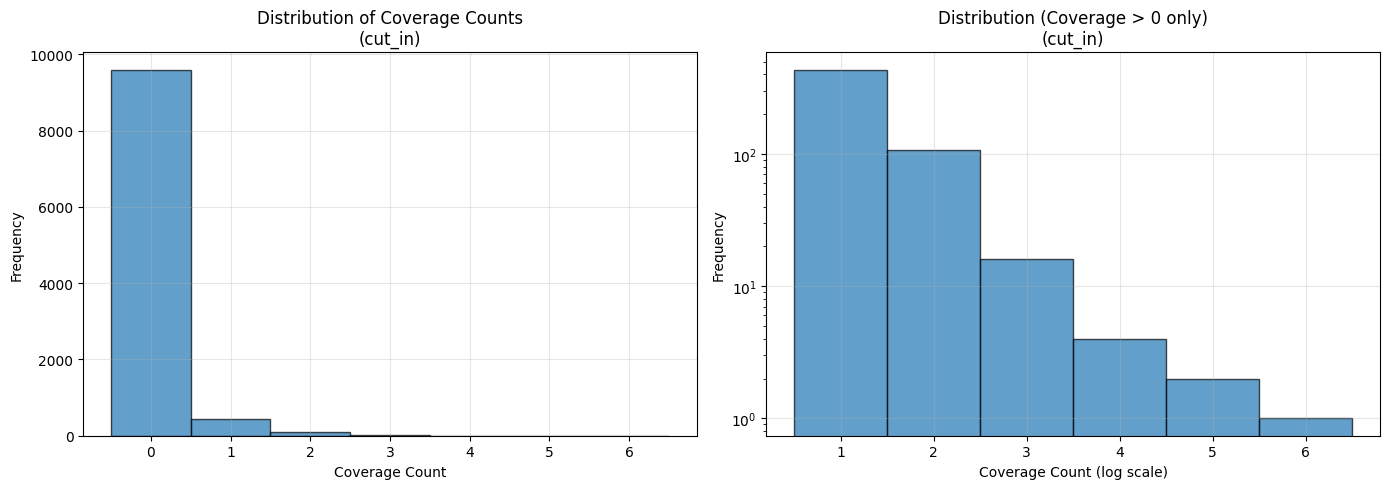

In [11]:
subgraph_df = coverage_df[coverage_df['subgraph_name'] == SUBGRAPH_NAME].copy()
subgraph_df['coverage_count'] = subgraph_df['coverage_count'].astype(int)

max_count = int(subgraph_df['coverage_count'].max())
bins = range(max_count + 2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(subgraph_df['coverage_count'], bins=bins, edgecolor='black', alpha=0.7, align='left')
axes[0].set_xlabel('Coverage Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Distribution of Coverage Counts\n({SUBGRAPH_NAME})')
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

non_zero = subgraph_df[subgraph_df['coverage_count'] > 0]['coverage_count']
if len(non_zero) > 0:
    max_non_zero = int(non_zero.max())
    bins_non_zero = range(1, max_non_zero + 2)
    axes[1].hist(non_zero, bins=bins_non_zero, edgecolor='black', alpha=0.7, align='left')
    axes[1].set_xlabel('Coverage Count (log scale)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Distribution (Coverage > 0 only)\n({SUBGRAPH_NAME})')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
else:
    axes[1].text(0.5, 0.5, 'No nodes with coverage > 0', 
                ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()



In [24]:
max_actors = 10

graph_stats = subgraph_df.groupby('graph_path').agg({
    'node_id': 'nunique',
    'coverage_count': 'sum'
}).reset_index()
graph_stats.columns = ['graph_path', 'num_actors', 'total_coverage']

graphs_with_few_actors = graph_stats[graph_stats['num_actors'] <= max_actors].copy()
graphs_with_few_actors = graphs_with_few_actors.sort_values('total_coverage', ascending=True)


In [25]:
VISUALIZE_INDEX = 0
selected_graph_id = graphs_with_few_actors.iloc[VISUALIZE_INDEX]['graph_path']
graph_coverage = subgraph_df[subgraph_df['graph_path'] == selected_graph_id].copy()
node_coverage_dict = dict(zip(graph_coverage['node_id'], graph_coverage['coverage_count']))

selected_row = coverage_df[coverage_df['graph_path'] == selected_graph_id].iloc[0]
actor_graph_path = selected_row['actor_graph_path']
timestamp = selected_row['timestamp']


In [26]:
actor_graph_filename = os.path.basename(actor_graph_path)
log_id = actor_graph_filename.replace('_actor_graph.pkl', '')

with open(actor_graph_path, "rb") as f:
    actor_graph = pickle.load(f)

dataroot = repo_root / "argoverse_data" / "train"
scenario, map = get_scenario_data(dataroot, log_id)



following_lead: 2 total edges

leading_vehicle: 0 total edges

neighbor_vehicle: 0 total edges

opposite_vehicle: 6 total edges


/Users/marius/code/graph_coverage/graph_creator/create_graph.py:203: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


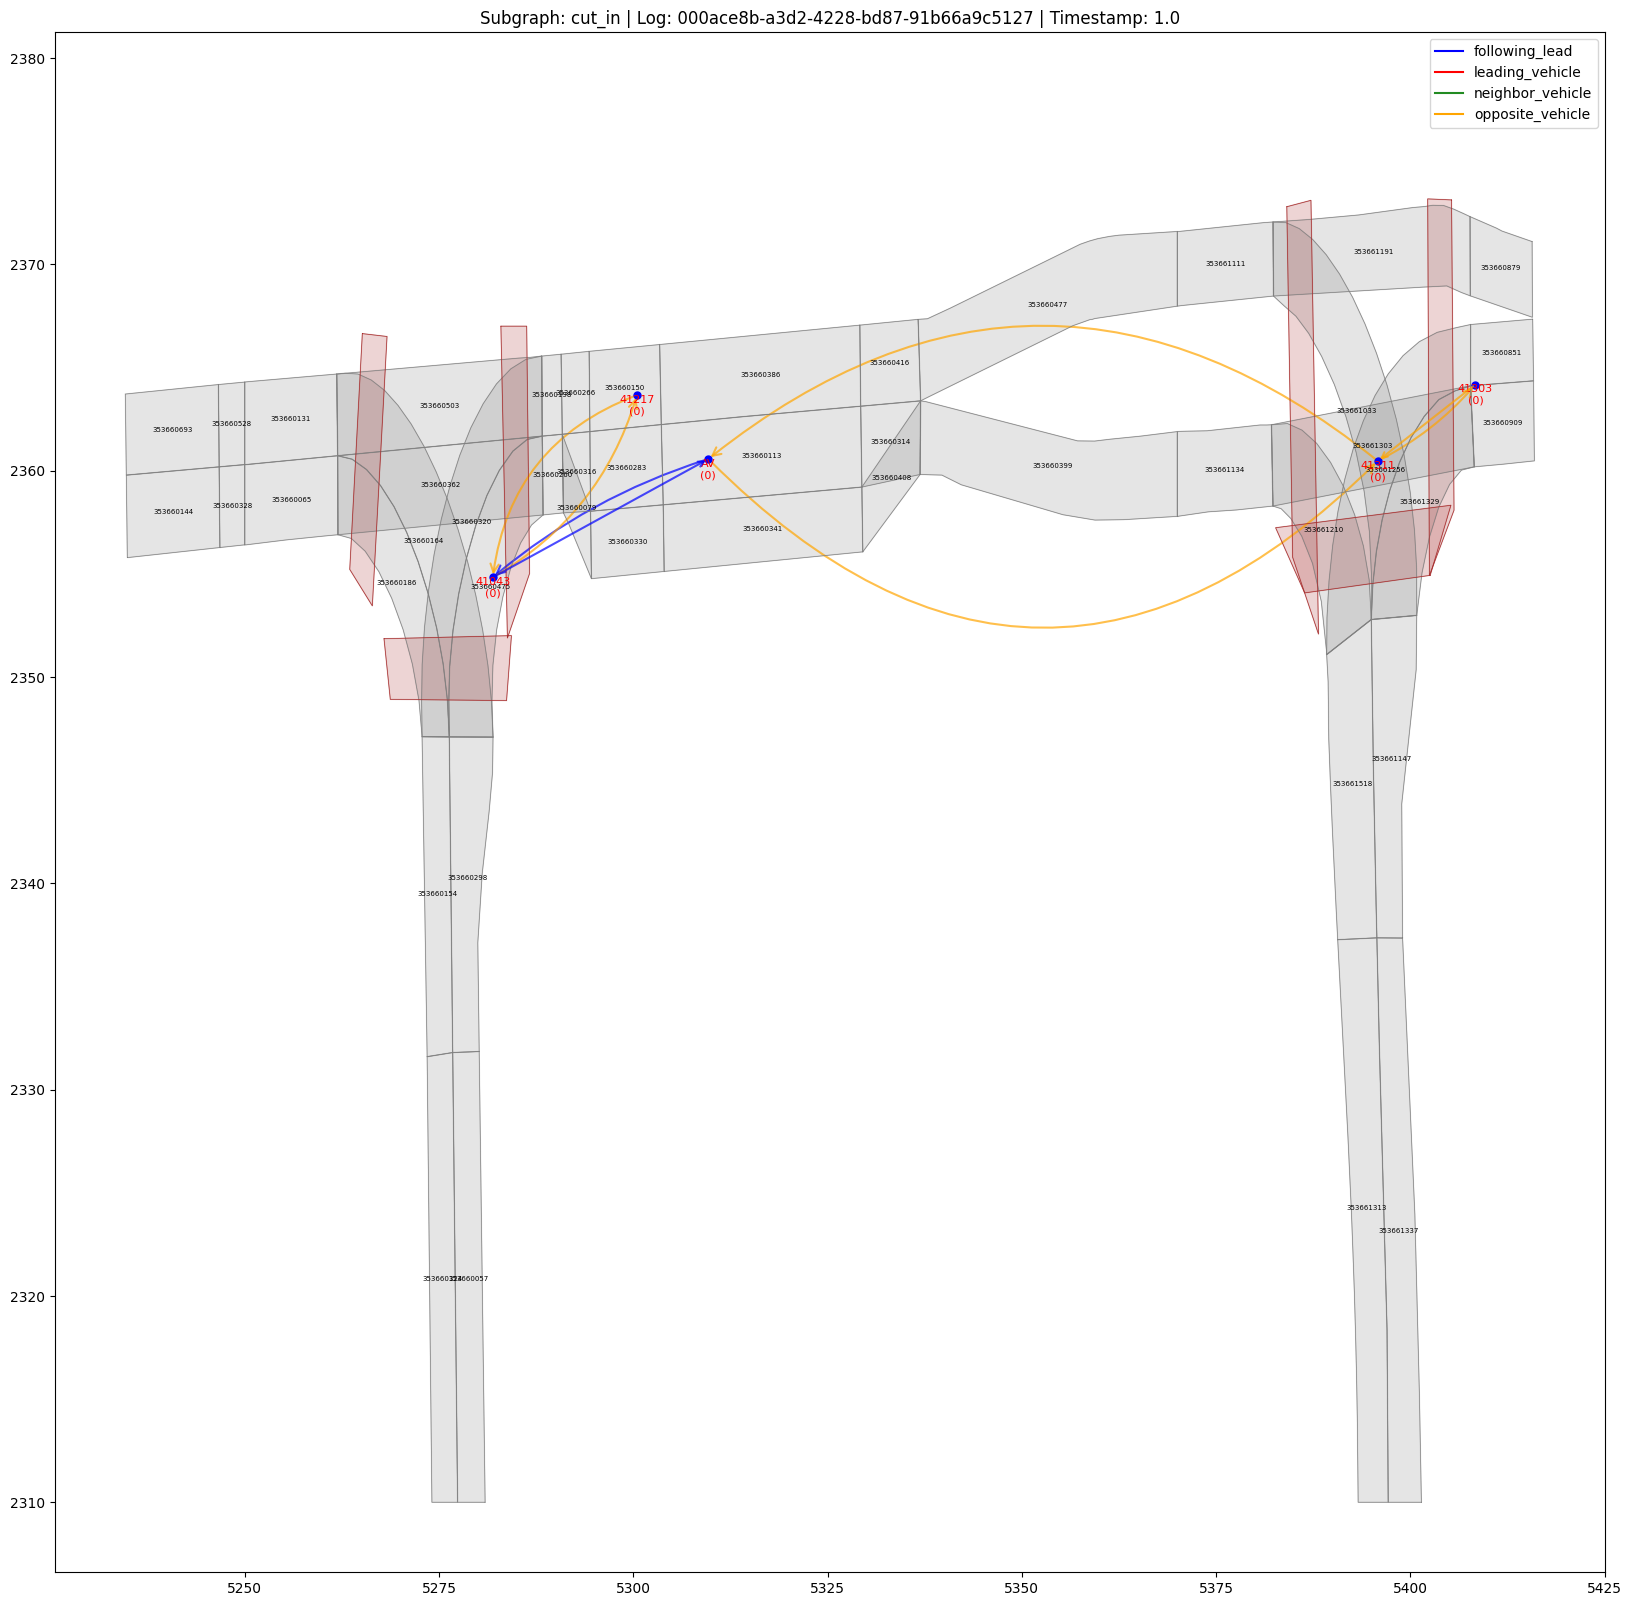

In [27]:
plot_scene_at_timestep(
    scenario, 
    map, 
    timestep=timestamp, 
    actor_graph=actor_graph,
    lane_label=True,
    node_coverage_dict=node_coverage_dict
)
plt.title(f"Subgraph: {SUBGRAPH_NAME} | Log: {log_id} | Timestamp: {timestamp}")
plt.show()
